# 10: Particle tracking with MODPATH
In this exercise, we will use MODPATH to simulate advective transport with the Freyberg flow model. For this exercise, we will use a quadtree version of the Freyberg model.

In [1]:
from IPython.display import clear_output, display
import pathlib as pl
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from flopy.utils.gridintersect import GridIntersect
import flopy
import pandas as pd

The location of the contamination patch and the nodes that the define bounding cells of the patch are calculated below.

In [2]:
# patch upper left and lower right
xmin, xmax = 250. * 1, 250. * 3
ymin, ymax = (40 - 14) * 250., (40 - 11) * 250. 

csx, csy = [xmin, xmin, xmax, xmax, xmin], [ymin, ymax, ymax, ymin, ymin]
polygon = [list(zip(csx, csy))]
(xmin, ymax), (xmax, ymin)

((250.0, 7250.0), (750.0, 6500.0))

--------------------------

### Define the workspace and model names.

In [3]:
load_ws = pl.Path('data/quadtree')
ws = pl.Path("temp/ex10a")
name = "project"
name_mp = f"{name}_mp"
exe_name = 'mf6'

## Load the MODFLOW 6 Model

Load a simulation object using `flopy.mf6.MFSimulation().load()`.

In [4]:
%%capture
sim = flopy.mf6.MFSimulation.load(sim_name=name, exe_name=exe_name,
                                    sim_ws=load_ws)

### Load the groundwater flow model

In [5]:
gwf = sim.get_model(name)
gwf.modelgrid

xll:0.0; yll:0.0; rotation:0.0; units:meters; lenuni:2

### Change the workspace

In [6]:
sim.set_sim_path(ws)

### Write the model files

In [7]:
%%capture
sim.write_simulation()

Run the simulation.

In [8]:
sim.run_simulation()

FloPy is using the following executable to run the model: ../../../../../../software/modflow_exes/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.4.2 06/28/2023

   MODFLOW 6 compiled Jun 28 2023 18:34:54 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor 

(True, [])

## Create and Run the MODPATH model


### Lets plot the model grid and the location of the contamination patch.

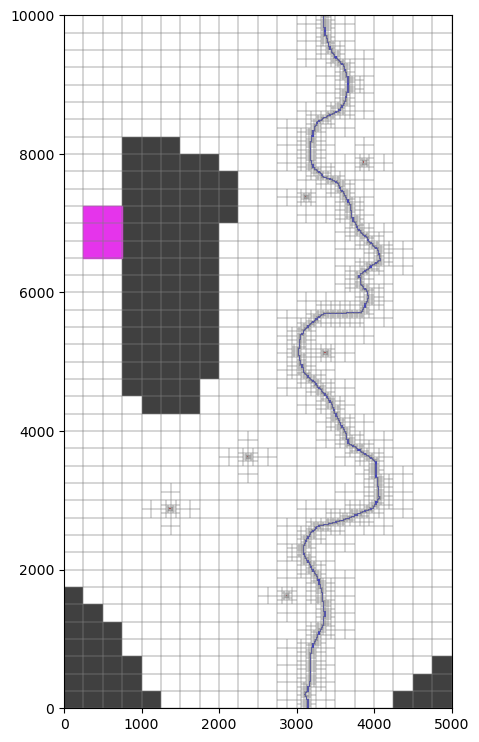

In [9]:
fig, ax = plt.subplots(figsize=(5, 9))
mm = flopy.plot.PlotMapView(gwf, layer=0, ax=ax)

mm.plot_bc('SFR', color="b", plotAll=True)
mm.plot_bc('WEL', plotAll=True)
mm.plot_inactive(alpha=0.75)

mm.plot_grid(lw=0.25, color='grey')

ax.fill(csx, csy, color='#e534eb');

Find the node numbers of the contamination patch using the groundwater model grid object and the `GridIntersect` utility. The `GridIntersect` utility has an `intersect` method that can be used to identified cellids from points, lines, and polygons.

In [10]:
gx = GridIntersect(gwf.modelgrid)
results = gx.intersect(polygon, 'Polygon')
nodes = results.cellids
nodes

array([1352, 1353, 1459, 1460, 1581, 1582], dtype=object)

### Create the MODPATH particle data

In [11]:
# create
sd = flopy.modpath.CellDataType()
p = flopy.modpath.NodeParticleData(subdivisiondata=[sd],
                                   nodes=list(nodes))
# create forward particle group
fpth = name_mp + '.sloc'
pg = flopy.modpath.ParticleGroupNodeTemplate(particlegroupname='contaminant',
                                             particledata=p,
                                             filename=fpth)

### Create the MODPATH 7 files

In [12]:
# create modpath files
mp = flopy.modpath.Modpath7(modelname=name_mp, flowmodel=gwf,
                            exe_name='mp7', model_ws=ws)
mpbas = flopy.modpath.Modpath7Bas(mp, porosity=0.1)
mpsim = flopy.modpath.Modpath7Sim(mp, simulationtype='pathline', 
                                  trackingdirection='forward',
                                  weaksinkoption='pass_through',
                                  weaksourceoption='pass_through',
                                  referencetime=0.,
                                  stoptimeoption='extend',
                                  particlegroups=pg)
help(flopy.modpath.Modpath7Sim)

Help on class Modpath7Sim in module flopy.modpath.mp7sim:

class Modpath7Sim(flopy.pakbase.Package)
 |  Modpath7Sim(model, mpnamefilename=None, listingfilename=None, endpointfilename=None, pathlinefilename=None, timeseriesfilename=None, tracefilename=None, simulationtype='pathline', trackingdirection='forward', weaksinkoption='stop_at', weaksourceoption='stop_at', budgetoutputoption='no', traceparticledata=None, budgetcellnumbers=None, referencetime=None, stoptimeoption='extend', stoptime=None, timepointdata=None, zonedataoption='off', stopzone=None, zones=0, retardationfactoroption='off', retardation=1.0, particlegroups=None, extension='mpsim')
 |  
 |  MODPATH Simulation File Package Class.
 |  
 |  Parameters
 |  ----------
 |  model : model object
 |      The model object (of type :class:`flopy.modpath.Modpath7`) to
 |      which this package will be added.
 |  mpnamefilename : str
 |      Filename of the MODPATH 7 name file. If mpnamefilename is not
 |      defined it will be gene

### Write MODPATH 7 files and run the model

In [13]:
# write modpath datasets
mp.write_input()

# run modpath
mp.run_model()

FloPy is using the following executable to run the model: ../../../../../../software/modflow_exes/mp7

MODPATH Version 7.2.001   
Program compiled Aug 01 2021 12:57:00 with IFORT compiler (ver. 19.10.3)        
 


 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+00  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
         0 particles remain active.
         0 particles terminated at boundary faces.
         0 particles terminated at weak sink cells.
         0 particles terminated at weak source cells.
       162 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Normal termination.                                                        


(True, [])

## Post-Process the MODFLOW and MODPATH Results


### Load MODFLOW and MODPATH results from the heads and pathline files

Load the MODFLOW heads

In [14]:
hobj = gwf.output.head()

In [15]:
hds = hobj.get_data()

Load the pathline file

In [16]:
ppth =ws / f"{name_mp}.mppth"
p = flopy.utils.PathlineFile(ppth)
p0 = p.get_alldata()

In [17]:
p0[0:2]

[array([( 291.66666, 7041.6665, 25.157747 ,     0.    , 0, 0),
        ( 292.26523, 7053.434 , 24.259151 ,  1066.6232, 0, 0),
        ( 296.87158, 7187.315 , 18.867577 ,  9176.828 , 1, 0),
        ( 298.29572, 7250.    , 17.83786  , 11656.656 , 2, 0),
        ( 327.38013, 7500.    , 17.041315 , 17482.574 , 2, 0),
        ( 351.95312, 7750.    , 14.886883 , 21403.549 , 2, 0),
        ( 384.25983, 8000.    , 14.738331 , 24241.266 , 2, 0),
        ( 437.98865, 8250.    , 15.478686 , 26416.283 , 2, 0),
        ( 500.     , 8325.292 , 14.165776 , 27109.031 , 2, 0),
        ( 692.9299 , 8500.    , 15.878951 , 28298.334 , 2, 0),
        ( 750.     , 8540.724 , 17.176243 , 28605.803 , 2, 0),
        (1000.     , 8630.868 , 14.297673 , 30072.422 , 2, 0),
        (1250.     , 8669.552 , 14.05823  , 31359.709 , 2, 0),
        (1500.     , 8683.525 , 15.129906 , 32383.266 , 2, 0),
        (1750.     , 8648.858 , 15.427488 , 33216.24  , 2, 0),
        (2000.     , 8599.475 , 13.062349 , 34121.06  ,

### Plot the heads and pathlines

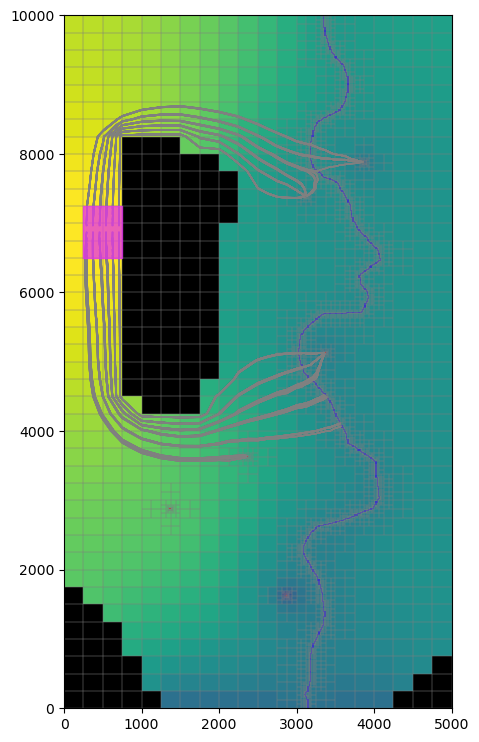

In [18]:
fig, ax = plt.subplots(figsize=(5, 9))
mm = flopy.plot.PlotMapView(model=gwf, layer=0, ax=ax)
mm.plot_array(hds, masked_values=[1e30])

mm.plot_bc('SFR', color='b', plotAll=True)
mm.plot_bc('WEL', plotAll=True)
mm.plot_ibound()
mm.plot_pathline(p0, layer='all', color='blue', lw=1)
mm.plot_grid(lw=0.2, color="0.5")

ax = plt.gca()
ax.fill(csx, csy, color='#e534eb', zorder=100, alpha=.75);

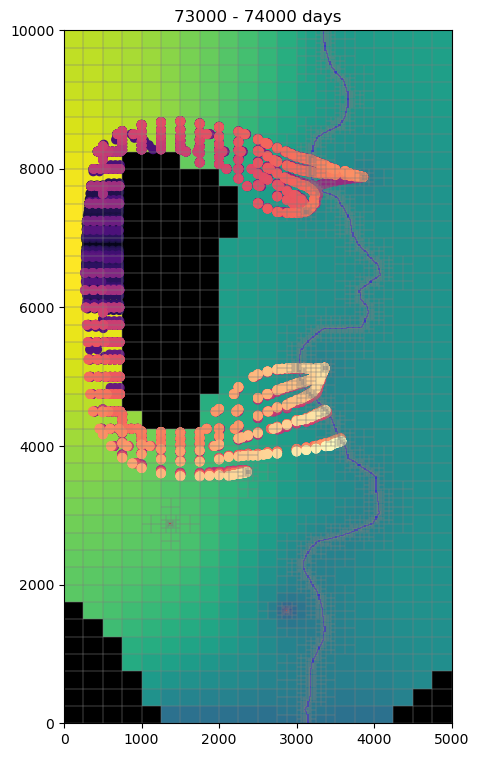

In [19]:
fig, ax = plt.subplots(figsize=(5, 9))

mm = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0)
mm.plot_array(hds, masked_values=[1e30])
mm.plot_bc('SFR', color='b', plotAll=True)
mm.plot_bc('WEL', plotAll=True)
mm.plot_ibound()
mm.plot_grid(lw=0.2, color="0.5")

p = flopy.utils.PathlineFile(ppth)
p0 = p.get_alldata()
df = pd.DataFrame.from_records(p0[0])
for ix, recarray in enumerate(p0):
    dft = pd.DataFrame.from_records(recarray)
    df = pd.concat((df, dft), ignore_index=True)
vmin, vmax = df.time.min(), df.time.max()

times = list(range(0, 74001, 1000))
for ix in range(1, len(times)):
    tmp = df[(df.time >= times[ix - 1]) & (df.time < times[ix])]
    s = ax.scatter(tmp.x.values, tmp.y.values, c=tmp.time.values, vmin=vmin, vmax=vmax, cmap="magma")
    ax.set_title(f"{times[ix - 1]} - {times[ix]} days")
    display(fig)
    clear_output(wait=True)
    plt.pause(0.1)    

### Export the pathlines to a shapefile

In [20]:
spth = pl.Path(ws / 'pathline.shp')
p.write_shapefile(p0, mg=gwf.modelgrid, one_per_particle=False, shpname=spth)

{'names': ['x', 'y', 'z', 'time', 'k', 'particleid'], 'formats': ['<f4', '<f4', '<f4', '<f4', '<i4', '<i4'], 'offsets': [20, 24, 28, 16, 32, 0], 'itemsize': 60}
No CRS information for writing a .prj file.
Supply an valid coordinate system reference to the attached modelgrid object or .export() method.


### Load the shapefile into geopandas

In [21]:
rshp = gpd.read_file(spth)

### Show the dataframe

In [22]:
rshp

,x,y,z,time,k,particleid,geometry
0,292.265228,7053.434082,24.259151,1066.623169,1,1,"LINESTRING (291.667 7041.667, 292.265 7053.434)"
1,296.871582,7187.314941,18.867577,9176.828125,2,1,"LINESTRING (292.265 7053.434, 296.872 7187.315)"
2,298.295715,7250.000000,17.837860,11656.656250,3,1,"LINESTRING (296.872 7187.315, 298.296 7250.000)"
3,327.380127,7500.000000,17.041315,17482.574219,3,1,"LINESTRING (298.296 7250.000, 327.380 7500.000)"
4,351.953125,7750.000000,14.886883,21403.548828,3,1,"LINESTRING (327.380 7500.000, 351.953 7750.000)"
...,...,...,...,...,...,...,...
7326,3312.500000,5125.320312,1.554207,49924.312500,3,162,"LINESTRING (3304.377 5125.000, 3312.500 5125.320)"
7327,3328.125000,5128.071289,1.580646,49943.050781,3,162,"LINESTRING (3312.500 5125.320, 3328.125 5128.071)"
7328,3343.750000,5128.837891,1.579881,49954.789062,3,162,"LINESTRING (3328.125 5128.071, 3343.750 5128.838)"
7329,3359.375000,5131.090332,1.578388,49959.777344,3,162,"LINESTRING (3343.750 5128.838, 3359.375 5131.090)"


### Plot the geopandas dataframe on the modelgrid

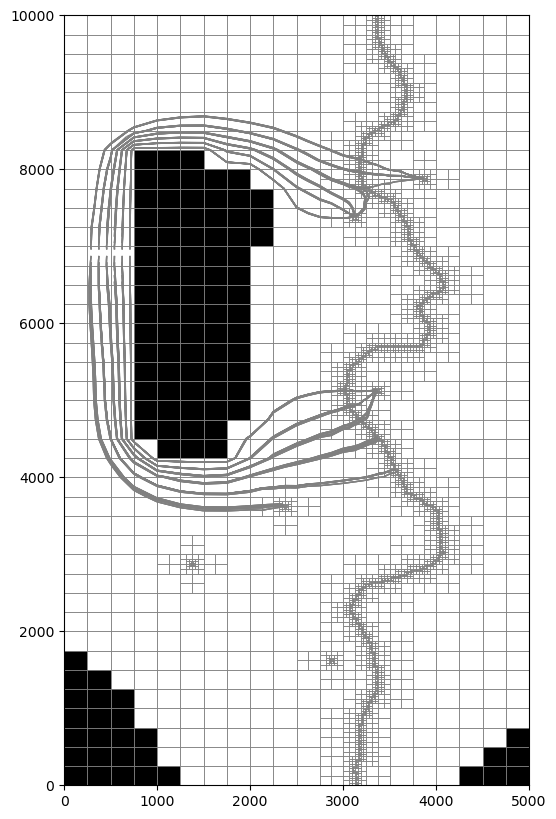

In [23]:
fig, ax = plt.subplots(figsize=(6, 10))
pmv = flopy.plot.PlotMapView(gwf, ax=ax)
pmv.plot_grid(lw=0.5)
pmv.plot_shapes(rshp.geometry.to_list(), edgecolor="grey") #, edgecolor="b")
pmv.plot_ibound();

## Export the data to VTK (Visualization ToolKit) format for a 3d representation

FloPy's `Vtk` module allows us to create Visualization ToolKit (VTK) files that can be opened and explored with pyVISTAs or external software such as ParaView.

In [24]:
from flopy.export.vtk import Vtk

vtk = Vtk(model=gwf, binary=False, vertical_exageration=50, smooth=False)
vtk.add_model(gwf)
vtk.add_pathline_points(p0)

Write VTK file for use in ParaView or other VTK software

In [25]:
pth = pl.Path("temp")
pth.mkdir(exist_ok=True)

vtk.write(pth / "freyberg")

## Alternatively we can visualize the VTK representation using `pyvista`. To activate these cells, set `plotvtk=True`

In [26]:
plotvtk = True
if plotvtk:
    import pyvista as pv

Convert the VTK to pyvista meshes and rotate the meshes to match the orientation of our matplotlib plots

In [27]:
if plotvtk:
    grid, pathlines = vtk.to_pyvista()

In [28]:
if plotvtk:
    axes = pv.Axes(show_actor=True, actor_scale=2.0, line_width=5)

    grid.rotate_z(160, point=axes.origin, inplace=True)
    pathlines.rotate_z(160, point=axes.origin, inplace=True)

Select particle release locations and build a dictionary of particle tracks (pathlines). This will be used below for particle labelling, as well as for animation.

*Note*: while below we construct pathlines manually from data read from the exported VTK files, pathlines may also be read directly from the MODPATH 7 pathline output file (provided the simulation was run in pathline or combined mode, as this one was).

In [29]:
if plotvtk:
    tracks = {}
    particle_ids = set()
    release_locs = list()

    for i, t in enumerate(pathlines["time"]):
        pid = str(round(float(pathlines["particleid"][i])))
        loc = pathlines.points[i]

        if pid not in tracks:
            tracks[pid] = []
            particle_ids.add(pid)
            release_locs.append(loc)

        # store the particle location in the corresponding track
        tracks[pid].append((loc, t))

    release_locs = np.array(release_locs)
    tracks = {k: np.array(v, dtype=object) for k, v in tracks.items()}
    max_track_len = max([len(v) for v in tracks.values()])

View the grid and pathlines with PyVista, with particle tracks/locations colored by time. Also add particle ID labels to a few particles’ release locations.

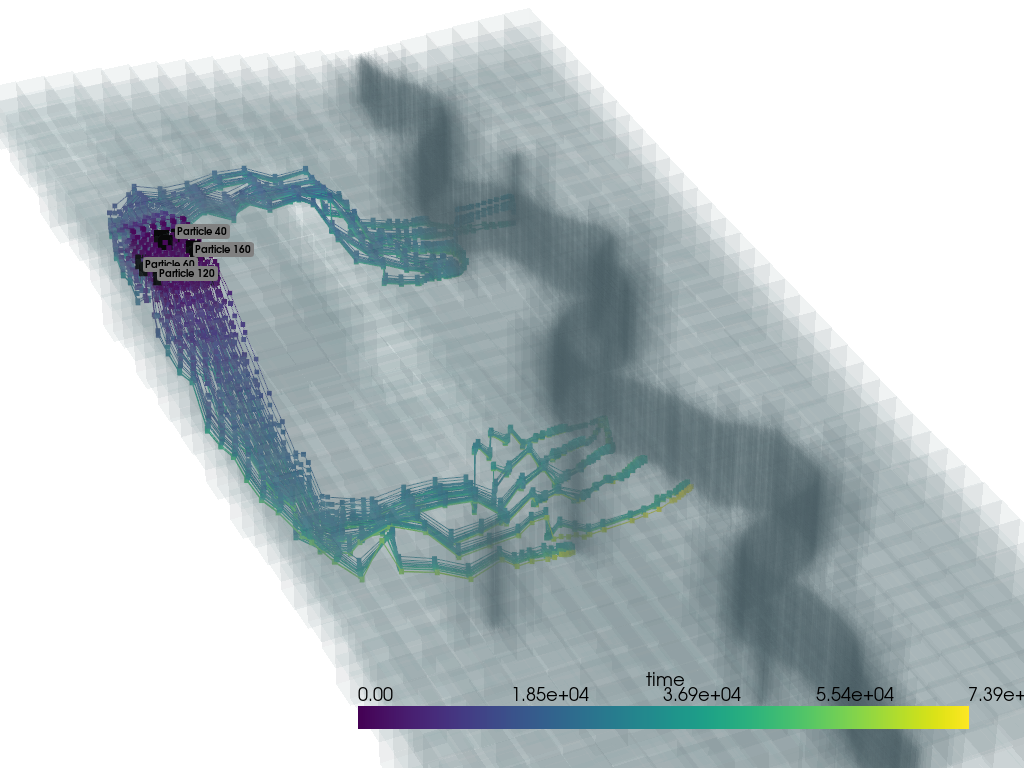

In [30]:
if plotvtk:
    pv.set_plot_theme("document")
    pv.set_jupyter_backend("static")

    # create the plot and add the grid and pathline meshes
    p = pv.Plotter()
    p.add_mesh(grid, opacity=0.05)
    p.add_mesh(pathlines, scalars="time")

    # add a particle ID label to each 20th particle's starting point
    label_coords = []
    start_labels = []
    for pid, track in tracks.items():
        if int(pid) % 20 == 0:
            label_coords.append(track[0][0])
            start_labels.append(f"Particle {pid}")

    p.add_point_labels(
        label_coords,
        start_labels,
        font_size=10,
        point_size=15,
        point_color="black",
    )

    # zoom in and show the plot
    p.camera.zoom(2.4)
    p.show()

Create an animated GIF of the particles traveling along their pathlines, with particles colored by time.

In [31]:
if plotvtk:
    # create plotter
    p = pv.Plotter(notebook=False, off_screen=True)

    # open GIF file
    gif_path = pth / f"freyberg_tracks.gif"
    p.open_gif(str(gif_path))

    # create mesh from release locations
    spls = pv.PolyData(release_locs)
    spls.point_data["time"] = np.zeros(len(spls.points))

    # add the underlying grid mesh and particle data, then zoom in
    p.add_mesh(grid, opacity=0.05)
    p.add_mesh(spls, clim=[0, 1.23e09])
    p.camera.zoom(2.4)

    # cycle through time steps and update particle location
    for i in range(1, max_track_len):
        pts = []
        times = []
        segments = []

        for pid in particle_ids:
            track = tracks[pid]
            npts = len(track)
            # use last locn if particle has already terminated
            loc, t = track[i] if i < npts else track[npts - 1]
            pts.append(loc)
            times.append(t)
            if i < npts:
                segments.append(track[i - 1][0])
                segments.append(loc)

        p.update_coordinates(np.vstack(pts), render=False)
        p.update_scalars(np.array(times), mesh=spls, render=False)
        p.add_lines(np.array(segments), width=1, color="black")
        p.write_frame()  # write frame to file

    # close the plotter and the GIF file
    p.close()

/Users/aleaf/mambaforge/envs/pyclass-docs/lib/python3.11/site-packages/pyvista/plotting/plotter.py:4722: PyVistaDeprecationWarning: This method is deprecated and will be removed in a future version of PyVista. Directly modify the points of a mesh in-place instead.
  warnings.warn(
/Users/aleaf/mambaforge/envs/pyclass-docs/lib/python3.11/site-packages/pyvista/plotting/plotter.py:4644: PyVistaDeprecationWarning: This method is deprecated and will be removed in a future version of PyVista. Directly modify the scalars of a mesh in-place instead.
  warnings.warn(


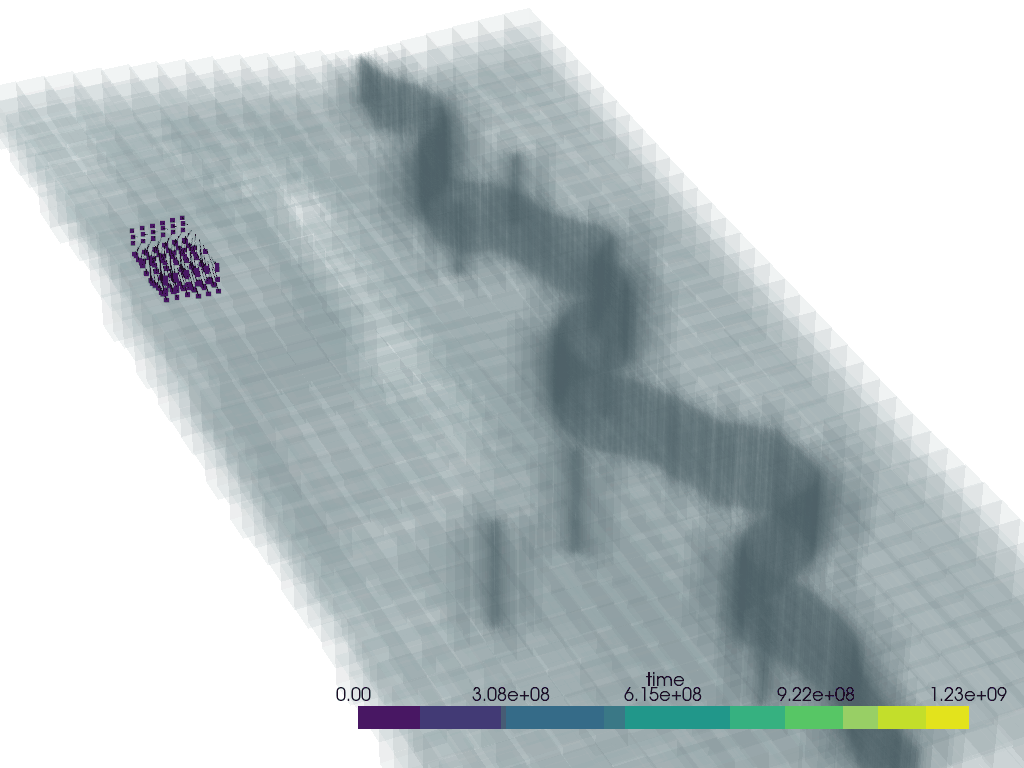

In [32]:
if plotvtk:
    from IPython.core.display import Image

    display(Image(data=open(gif_path, "rb").read(), format="gif"))